# Objetivo

Analizar la base de datos **dataset_SCL.csv** que contiene información de los vuelos, en el dataset se encuentran las siguiente columnas con su descripción:

| Variable | Descripción |
| :- | :- |
| **Fecha-I**  | Fecha y hora programada del vuelo.
| **Vlo-I** | Número de vuelo programado.
| **Ori-I** | Código de ciudad de origen programado.
| **Des-I** | Código de ciudad de destino programado.
| **Emp-I** | Código aerolínea de vuelo programado.
| **Fecha-O** | Fecha y hora de operación del vuelo.
| **Vlo-O** | Número de vuelo de operación del vuelo.
| **Ori-O** | Código de ciudad de origen de operación.
| **Des-O** | Código de ciudad de destino de operación.
| **Emp-O** | Código aerolínea de vuelo operado.
| **DIA** | Día del mes de operación del vuelo.
| **MES** | Número de mes de operación del vuelo.
| **AÑO** | Año de operación del vuelo.
| **DIANOM** | Día de la semana de operación del vuelo.
| **TIPOVUELO** | Tipo de vuelo, I = Internacional, N = Nacional
| **OPERA** | Nombre de aerolínea que opera.
| **SIGLAORI** | Nombre de ciudad de origen.
| **SIGLADES** | Nombre ciudad destino.

Para este estudio se busca identificar el comportamiento de las variables y la construcción de nuevas variables que nos permitan generar un modelo que prediga si un vuelo va a salir con retraso.

Este modelo tiene un gran impacto a nivel empresarial debido a que muchas personas tienden a comprar vuelos con escalas, y si un vuelo se retrasa les puede impactar significativa y la empresa debe hacerse cargo por la falta de no entregar un servicio adecuado.

In [1]:
# Librerías a utilizar
import os
import pandas as pd
import numpy as np
from datetime import datetime

# Para graficar
import seaborn as sns
import matplotlib.pyplot as plt

# Estadístico para la normalidad
from scipy.stats import shapiro

# Preprocesamiento de variables categóricas
from sklearn.preprocessing import OneHotEncoder

# Split data and grid search
from sklearn.model_selection import train_test_split, GridSearchCV

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from xgboost import XGBClassifier
# Metrics
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix

# save models
import pickle

import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns",None)

# Cambio de directorio
os.chdir("..")

from utilities import *
from config import *

In [2]:
path_save_synthetic_features = "data/synthetic_features.csv"
path_load_scl = "data/dataset_SCL.csv"

In [3]:
# Lectura de la data
df_scl = pd.read_csv(path_load_scl)

In [4]:
# Normalización de las columnas
df_scl.columns = [col.upper().replace("-","_") for col in df_scl.columns]
df_scl = df_scl.rename({"AÑO":"YEAR"},axis=1)

In [5]:
# Revisar cantidad de filas y columnas del dataset
df_scl.shape

(68206, 18)

In [6]:
df_scl.head()

,FECHA_I,VLO_I,ORI_I,DES_I,EMP_I,FECHA_O,VLO_O,ORI_O,DES_O,EMP_O,DIA,MES,YEAR,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


In [7]:
resume_col(df=df_scl,col="TIPOVUELO")

,TIPOVUELO,CONTEO,PORCENTAJE
0,N,36966,54.198%
1,I,31240,45.802%


In [8]:
resume_col(df=df_scl,col="DES_I")

,DES_I,CONTEO,PORCENTAJE
0,SCFA,5787,8.485%
1,SPJC,5270,7.727%
2,SCCF,5145,7.543%
3,SCTE,4357,6.388%
4,SCIE,3995,5.857%
...,...,...,...
59,SBFI,1,0.001%
60,SPSO,1,0.001%
61,SEQU,1,0.001%
62,SEQM,1,0.001%


In [9]:
resume_col(df=df_scl,col="DES_O")

,DES_O,CONTEO,PORCENTAJE
0,SCFA,5786,8.483%
1,SPJC,5270,7.727%
2,SCCF,5146,7.545%
3,SCTE,4357,6.388%
4,SCIE,3993,5.854%
...,...,...,...
58,SEQM,2,0.003%
59,KIAD,1,0.001%
60,SPSO,1,0.001%
61,EGYP,1,0.001%


In [10]:
resume_col(df=df_scl,col="EMP_I")

,EMP_I,CONTEO,PORCENTAJE
0,LAN,37611,55.143%
1,SKU,14298,20.963%
2,TAM,3049,4.47%
3,ARG,1949,2.858%
4,CMP,1850,2.712%
5,LAW,1574,2.308%
6,AVA,1152,1.689%
7,JAT,1095,1.605%
8,GLO,806,1.182%
9,AAL,757,1.11%


In [11]:
resume_col(df=df_scl,col="EMP_O")

,EMP_O,CONTEO,PORCENTAJE
0,LAN,20988,30.771%
1,LXP,14558,21.344%
2,SKU,14298,20.963%
3,TAM,3046,4.466%
4,ARG,1946,2.853%
5,CMP,1850,2.712%
6,JMR,1647,2.415%
7,LPE,1214,1.78%
8,JAT,1095,1.605%
9,AVA,885,1.298%


In [12]:
resume_col(df=df_scl,col="DIANOM")

,DIANOM,CONTEO,PORCENTAJE
0,Viernes,10292,15.09%
1,Jueves,10251,15.029%
2,Lunes,10131,14.854%
3,Domingo,9796,14.362%
4,Miercoles,9722,14.254%
5,Martes,9662,14.166%
6,Sabado,8352,12.245%


In [13]:
resume_col(df=df_scl,col="SIGLAORI")

,SIGLAORI,CONTEO,PORCENTAJE
0,Santiago,68206,100.0%


In [14]:
resume_col(df=df_scl,col="SIGLADES").head(10)

,SIGLADES,CONTEO,PORCENTAJE
0,Buenos Aires,6335,9.288%
1,Antofagasta,5786,8.483%
2,Lima,5270,7.727%
3,Calama,5146,7.545%
4,Puerto Montt,4357,6.388%
5,Concepcion,3993,5.854%
6,Iquique,3747,5.494%
7,Sao Paulo,3569,5.233%
8,Temuco,2589,3.796%
9,Arica,2436,3.572%


In [15]:
# El 80% de los viajes se manejan sobre el Grupo LATAM o Sky Airline
resume_col(df=df_scl,col="OPERA")

,OPERA,CONTEO,PORCENTAJE
0,Grupo LATAM,40892,59.954%
1,Sky Airline,14298,20.963%
2,Aerolineas Argentinas,1949,2.858%
3,Copa Air,1850,2.712%
4,Latin American Wings,1674,2.454%
5,Avianca,1152,1.689%
6,JetSmart SPA,1095,1.605%
7,Gol Trans,806,1.182%
8,American Airlines,757,1.11%
9,Air Canada,565,0.828%


### Observaciones

- Casi todos los días de la semana tienen un porcentaje similar.
- El grupo LATAM y Sky Airline abarcan casi la totalidad de vuelos, que es aproximadamente un 80% (OPERA).
- Existe incosistencia en el proveedor del vuelo, debido a que LATAM son aproximadamente 55% de los vuelos programados, pero al contrastar estos datos con el que realmente fue efectuado bajan a aproximadamente un 30% operados.
- Todos los viajes salen desde Santiago.
- El destino más solicitado en este periodo fue Buenos Aires.
- Un 54.2% de los vuelos son nacionales y un 45.8% de los vuelos son internacionales.
- En general existen diferencias entre los vuelos programados y los que realmente fueron operados.
### Supuesto
Se considera la fecha de operación la cual se realizó el vuelo, para esto es de interés saber cuantos vuelos tuvieron retraso, por lo que procedemos a calcular la diferencia entre la fecha de operación y la fecha programada del vuelo ($Fecha_O - Fecha_I$).

Además, se procede a calcular otras variables
- **temporada_alta**: 1 si la fecha del vuelo está en temporada alta y 0 si está en baja.
- **date_fmt**: Fecha formateada en formato %Y-%m-%d
- **atraso_15**: 1 si el vuelo tiene un atraso de al menos 15 minutos y 0 en otro caso.
- **operador**: Mantendrá los operadores Grupo LATAM y Sky Airline que representan el 80% de los vuelos.
- **destino_freq**: Dejaremos los 10 destinos más frecuentes
- **freq_vuelos**: Cantidad de vuelos en la misma hora.

In [16]:
# Calculo de retraso de un vuelo (diferencia en minutos)
df_scl['dif_min'] = df_scl.apply(lambda row: diff_minutes(start=row['FECHA_I'], end=row['FECHA_O']), axis=1)
# Calculo de la temporada (alta o baja)
df_scl["temporada_alta"] = df_scl.FECHA_I.map(temporada_alta)
# Calculo de la fecha normalizada
df_scl["date_fmt"] = df_scl["FECHA_I"].map(date2date)
# Calculo de un atraso de 15 minutos
df_scl["atraso_15"] = df_scl["dif_min"].map(retraso)
# Calculo del periodo del día (mañana, tarde o noche)
df_scl["periodo_dia"] = df_scl["FECHA_I"].map(periodo_dia)
# Calculo de variable operador
list_opera = resume_col(df=df_scl,col="OPERA").head(2).OPERA.tolist()
df_scl.loc[df_scl.OPERA==list_opera[0],"operador"] = list_opera[0]
df_scl.loc[df_scl.OPERA==list_opera[1],"operador"] = list_opera[1]
# Destino frecuentes
list_siglades = resume_col(df=df_scl,col="SIGLADES").head(10).SIGLADES.tolist()
df_scl.loc[df_scl["SIGLADES"]==list_siglades[0], "destino_freq"] = list_siglades[0]
df_scl.loc[df_scl["SIGLADES"]==list_siglades[1], "destino_freq"] = list_siglades[1]
df_scl.loc[df_scl["SIGLADES"]==list_siglades[2], "destino_freq"] = list_siglades[2]
df_scl.loc[df_scl["SIGLADES"]==list_siglades[3], "destino_freq"] = list_siglades[3]
df_scl.loc[df_scl["SIGLADES"]==list_siglades[4], "destino_freq"] = list_siglades[4]
df_scl.loc[df_scl["SIGLADES"]==list_siglades[5], "destino_freq"] = list_siglades[5]
df_scl.loc[df_scl["SIGLADES"]==list_siglades[6], "destino_freq"] = list_siglades[6]
df_scl.loc[df_scl["SIGLADES"]==list_siglades[7], "destino_freq"] = list_siglades[7]
df_scl.loc[df_scl["SIGLADES"]==list_siglades[8], "destino_freq"] = list_siglades[8]
df_scl.loc[df_scl["SIGLADES"]==list_siglades[9], "destino_freq"] = list_siglades[9]
# Reemplazar los datos faltantes
df_scl = df_scl.fillna({"operador":"OTRO","destino_freq":"OTRO"})
# Frecuencia de vuelos
resume = resume_col(df=df_scl,col="FECHA_I")
resume = resume[["FECHA_I","CONTEO"]].rename({"CONTEO":"freq_vuelos"},axis=1)
df_scl = df_scl.merge(resume,on="FECHA_I",how="left")

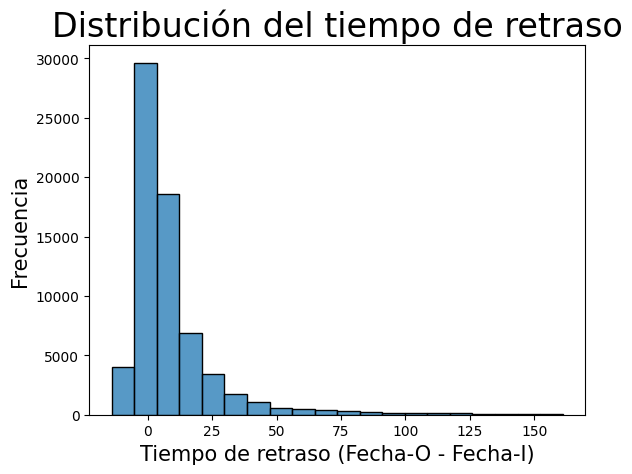

In [17]:
plt.title('Distribución del tiempo de retraso',fontsize=24)
sns.histplot(data=df_scl,x="dif_min",bins=20)
plt.ylabel("Frecuencia",fontsize=15)
plt.xlabel("Tiempo de retraso (Fecha-O - Fecha-I)",fontsize=15)
plt.show()

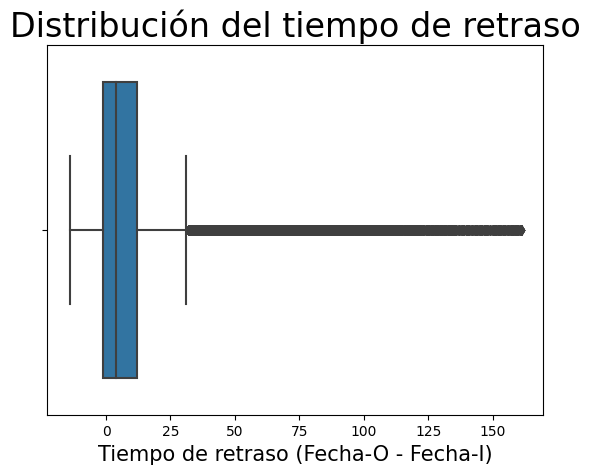

In [18]:
plt.title('Distribución del tiempo de retraso',fontsize=24)
sns.boxplot(df_scl.dif_min)
plt.xlabel("Tiempo de retraso (Fecha-O - Fecha-I)",fontsize=15)
plt.show()

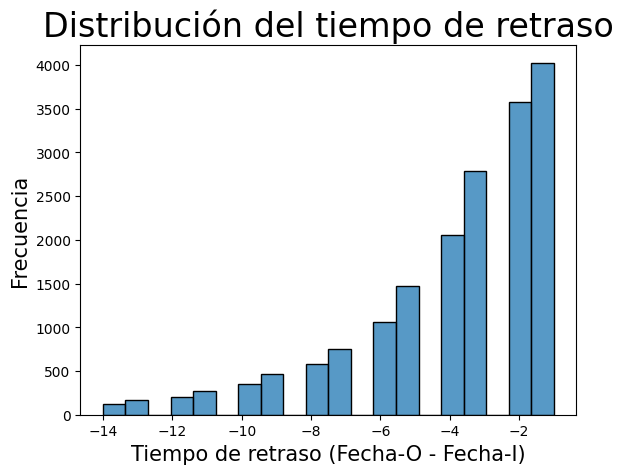

In [19]:
plt.title('Distribución del tiempo de retraso',fontsize=24)
resume = df_scl[df_scl["dif_min"]<0]
sns.histplot(data=resume,x="dif_min",bins=20)
plt.ylabel("Frecuencia",fontsize=15)
plt.xlabel("Tiempo de retraso (Fecha-O - Fecha-I)",fontsize=15)
plt.show()

## Observaciones:
- Existen datos negativos, esto quiere decir que el vuelo salió antes de la hora programada.
- Existe una asimetría hacia la derecha, lo cual existen vuelos con bastante retraso.
- Presencia de datos atípicos.
- No existe una gran diferencia de tiempo de aquellos vuelos que salieron antes de la hora programada.

### Calculo de datos atípicos

In [20]:
outliers, not_outliers = get_outliers(df_scl.dif_min)

In [21]:
print(f"Cantidad de datos outliers: {outliers.shape[0]}")
print(f"Cantidad de datos no outliers: {not_outliers.shape[0]}")

Cantidad de datos outliers: 5198
Cantidad de datos no outliers: 63008


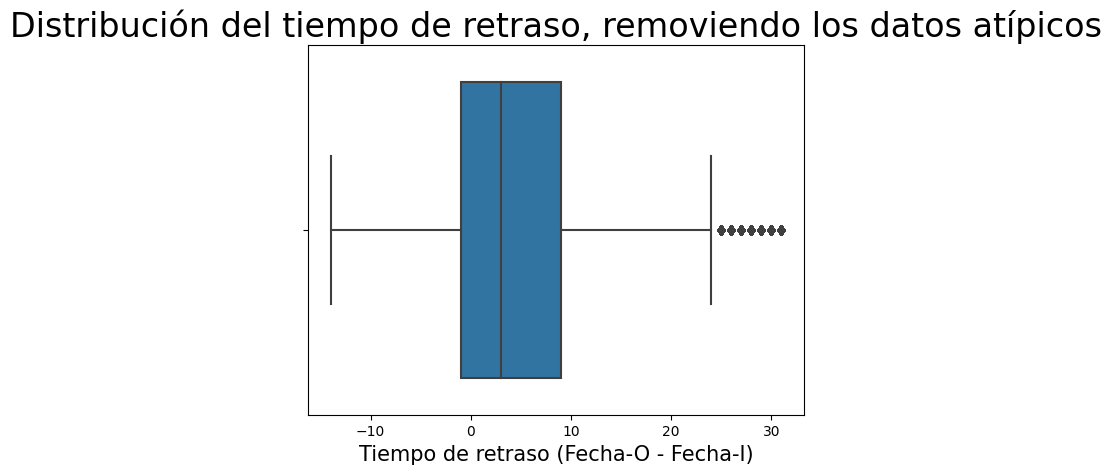

In [22]:
plt.title('Distribución del tiempo de retraso, removiendo los datos atípicos',fontsize=24)
ax = sns.boxplot(not_outliers)
plt.xlabel("Tiempo de retraso (Fecha-O - Fecha-I)",fontsize=15)
plt.show()

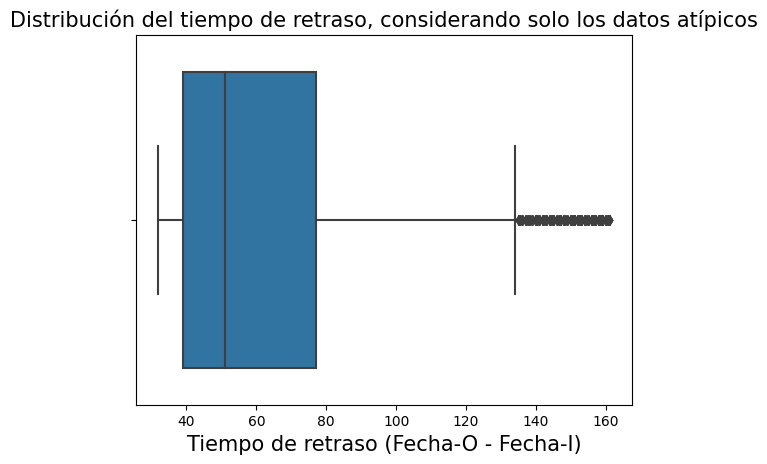

In [23]:
plt.title('Distribución del tiempo de retraso, considerando solo los datos atípicos',fontsize=15)
sns.boxplot(outliers)
plt.xlabel("Tiempo de retraso (Fecha-O - Fecha-I)",fontsize=15)
plt.show()

In [24]:
df_scl[df_scl["dif_min"]<0].shape

(17910, 26)

In [25]:
df_scl[df_scl["dif_min"]>=min(outliers)].shape[0]

5198

In [26]:
shapiro(df_scl["dif_min"])

ShapiroResult(statistic=0.6495827436447144, pvalue=0.0)

In [27]:
shapiro(not_outliers)

ShapiroResult(statistic=0.9482958912849426, pvalue=0.0)

## Observaciones
Se calcularon los datos atípicos y según su distribución todos aquellos vuelos con un retraso mayor a 31 minutos son considerados datos atípicos.
Se tienen 17910 vuelos que salieron antes de su hora programdo. Además, se tienen 5198 vuelos que son considerados outliers, esto quiere decir, que tuvieron un retraso de al menos 31 minutos.

Los datos no siguen una distribución normal, tanto para los datos con outliers, cómo para los datos sin los outliers. Por lo tanto, se debe considerar un modelo que no requiera el supuesto de normalidad de los datos.

In [28]:
resume_col(df=df_scl,col="atraso_15")

,atraso_15,CONTEO,PORCENTAJE
0,0,55592,81.506%
1,1,12614,18.494%


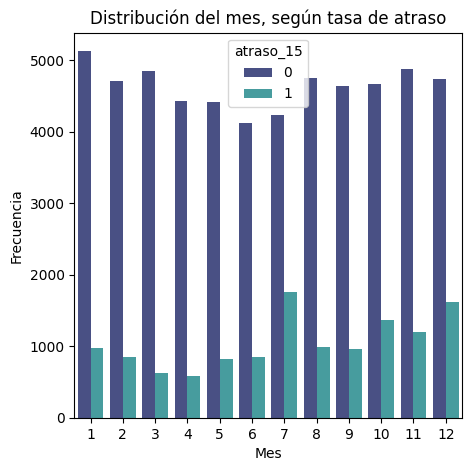

In [29]:
plt.figure(figsize=(5,5))
plt.title("Distribución del mes, según tasa de atraso")
ax = sns.countplot("MES",hue="atraso_15",data=df_scl,palette="mako")
plt.xlabel("Mes")
plt.ylabel("Frecuencia")
plt.show()

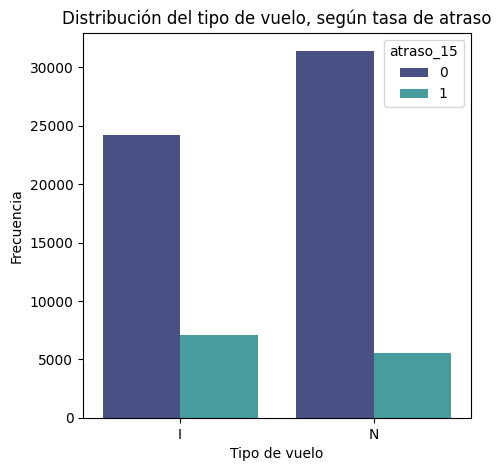

In [30]:
plt.figure(figsize=(5,5))
plt.title("Distribución del tipo de vuelo, según tasa de atraso")
ax = sns.countplot("TIPOVUELO",hue="atraso_15",data=df_scl,palette="mako")
plt.ylabel("Frecuencia")
plt.xlabel("Tipo de vuelo")
plt.show()

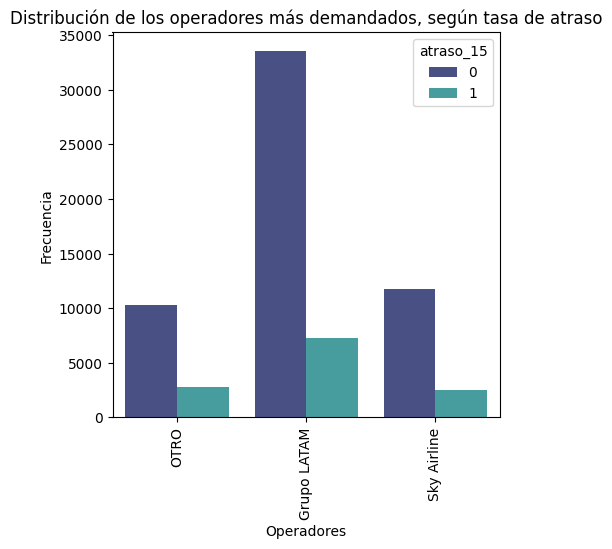

In [31]:
plt.figure(figsize=(5,5))
plt.title("Distribución de los operadores más demandados, según tasa de atraso")
ax = sns.countplot("operador",hue="atraso_15",data=df_scl,palette="mako")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.ylabel("Frecuencia")
plt.xlabel("Operadores")
plt.show()

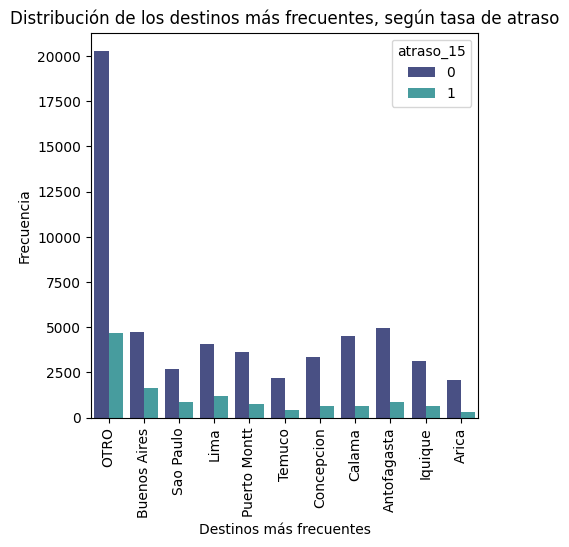

In [32]:
plt.figure(figsize=(5,5))
plt.title("Distribución de los destinos más frecuentes, según tasa de atraso")
ax = sns.countplot("destino_freq",hue="atraso_15",data=df_scl,palette="mako")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.ylabel("Frecuencia")
plt.xlabel("Destinos más frecuentes")
plt.show()

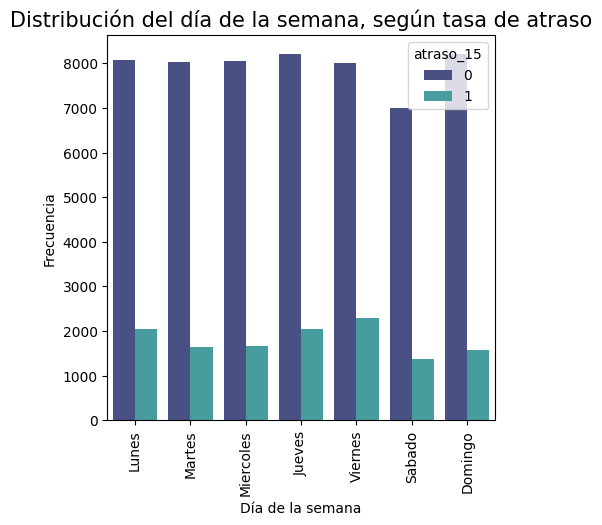

In [33]:
plt.figure(figsize=(5,5))
plt.title("Distribución del día de la semana, según tasa de atraso",fontsize=15)
ax = sns.countplot("DIANOM",hue="atraso_15",data=df_scl,palette="mako",order=["Lunes","Martes","Miercoles","Jueves","Viernes","Sabado","Domingo"])
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.ylabel("Frecuencia")
plt.xlabel("Día de la semana")
plt.show()

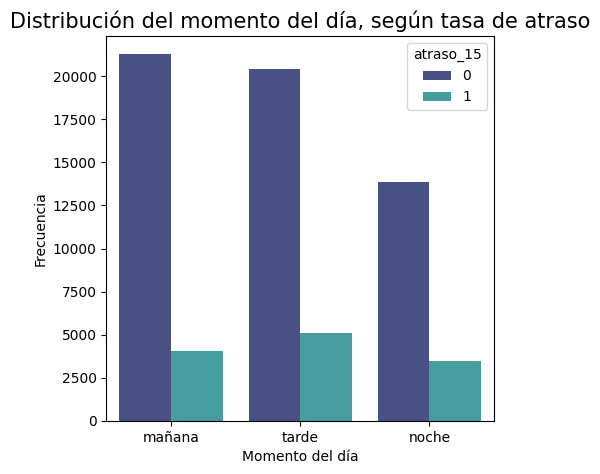

In [34]:
plt.figure(figsize=(5,5))
plt.title("Distribución del momento del día, según tasa de atraso",fontsize=15)
ax = sns.countplot("periodo_dia",hue="atraso_15",data=df_scl,palette="mako",order=["mañana","tarde","noche"])
plt.ylabel("Frecuencia")
plt.xlabel("Momento del día")
plt.show()

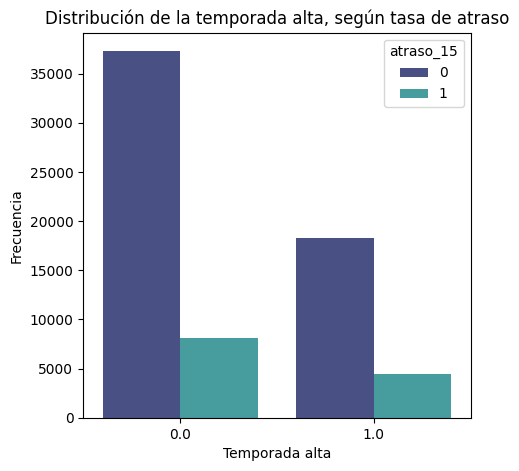

In [35]:
plt.figure(figsize=(5,5))
plt.title("Distribución de la temporada alta, según tasa de atraso")
ax = sns.countplot("temporada_alta",hue="atraso_15",data=df_scl,palette="mako")
plt.xlabel("Temporada alta")
plt.ylabel("Frecuencia")
plt.show()

### Observaciones
Se dispone de la variable objetivo cómo que ha tenido un retraso de 15 minutos o no (1 o 0). Los datos se encuentran desbalanceados de 81.5% para el 0 (que no tuvo retraso el vuelo) y 18.5% para el 1 (que obtuvo un retraso de al menos 15 minutos).

De las gráficas anteriores se concluye:
- Los meses de Julio y Diciembre son los meses que los vuelos más atrasos presentan. Sin embargo, la mayor tasa de atrasos se presentan en Julio.
- Los vuelos internacionales presentan una mayor tasa de atraso por sobre los nacionales (considerando que los viajes nacionales son más que los viajes internacionales).
- El día con mayor retraso se presenta el día viernes.
- El momento del día con mayor tasa de atraso se encuentra en la tarde (entre las 12:00 hrs y las 18:59 hrs).

In [36]:
df_scl.to_csv(path_save_synthetic_features,index=0)

In [37]:
df = pd.read_csv(path_save_synthetic_features)

# Preprocesamiento de datos
- La variable objetivo es **atraso_15**
- Las variables explicativas son: 
    - **DIANOM**
    - **TIPOVUELO**
    - **periodo_dia**
    - **temporada_alta**
    - **SIGLADES**
Se transformarán a variables dummies todas aquellas variables del tipo categóricas.
# Modelado
Se construirá un modelo que prediga si un vuelo tendrá retraso de al menos 15 minutos. Para esto, construiremos modelos los siguientes modelos:
   - Con todas las observaciones (1 modelo)
   - Dividido por cada día de la semana (7 modelos)
   - Dividido por cada momento del día (3 modelos)
   
Los modelos seleccionados que se proponen para desarrollar la probabilidad de identificar un atraso son:
   - Regresión Logística
   - Naive Bayes
   - Naive Bayes Multinomial
   - Random Forest
   - Xgboost
   
Debido al gran desbalance de clases las métricas más adecuadas para este problema son:
   - Matriz de confusión:
   
|Valor Predicho \ Valor Real| Valor positivo | Valor Negativo |
|:-|:- | :- |
|| TP | FP |
|| FN | TN
   - Precision:$$\frac{TP}{TP+FP}$$
   - Recall: $$\frac{TP}{TP+FN}$$
   - F1-score: $$2\cdot \frac{Precision \cdot Recall}{Precision + Recall}$$

Estás métricas nos ayudarán a ver que capacidad predictiva tiene el modelo.

In [38]:
df.head()

,FECHA_I,VLO_I,ORI_I,DES_I,EMP_I,FECHA_O,VLO_O,ORI_O,DES_O,EMP_O,DIA,MES,YEAR,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,dif_min,temporada_alta,date_fmt,atraso_15,periodo_dia,operador,destino_freq,freq_vuelos
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami,3.0,1.0,2017-01-01,0,noche,OTRO,OTRO,1
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami,9.0,1.0,2017-01-02,0,noche,OTRO,OTRO,1
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami,9.0,1.0,2017-01-03,0,noche,OTRO,OTRO,1
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami,3.0,1.0,2017-01-04,0,noche,OTRO,OTRO,1
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami,-2.0,1.0,2017-01-05,0,noche,OTRO,OTRO,1


In [39]:
df.columns = [col.upper() for col in df.columns]

In [40]:
features = ['TEMPORADA_ALTA', 'PERIODO_DIA','MES', 'OPERADOR', 'DESTINO_FREQ', 'FREQ_VUELOS', 'TIPOVUELO', 'DIANOM']
target = "ATRASO_15"
var_num = ["FREQ_VUELOS",'MES']
metrics=None
path_metrics = "data/metrics_models/metrics.parquet"

# Entrenamiento del modelo con toda la información

In [43]:
df_feat = df[features]
var_cat = [col for col in df_feat.columns if col not in var_num]
var_dummies = pd.get_dummies(df_feat[var_cat])
var_dummies[var_num[0]] = df[[var_num[0]]]
var_dummies[var_num[1]] = df[[var_num[1]]]
X = var_dummies
y = df[target]

rf
Fitting 5 folds for each of 60 candidates, totalling 300 fits


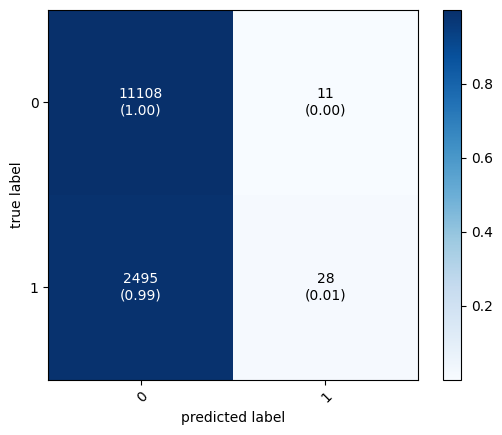

[INFO] model rf demoró 3.5415982166666664 minutos en ejecutar
rl
Fitting 5 folds for each of 30 candidates, totalling 150 fits


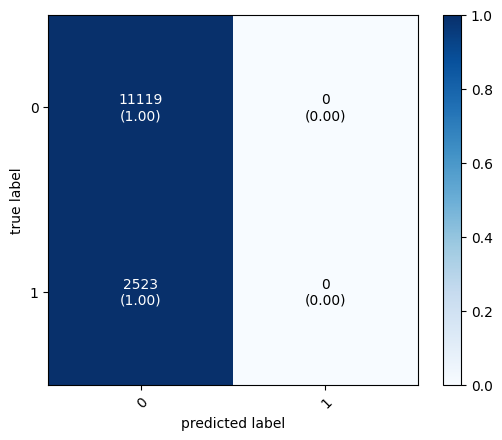

[INFO] model rl demoró 3.5886992833333333 minutos en ejecutar
xgb
Fitting 5 folds for each of 18 candidates, totalling 90 fits


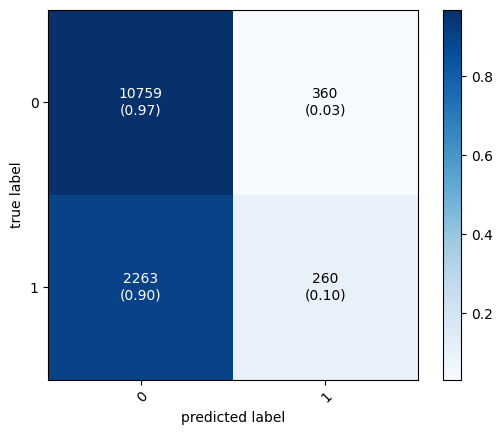

[INFO] model xgb demoró 2.8159061166666666 minutos en ejecutar
nb


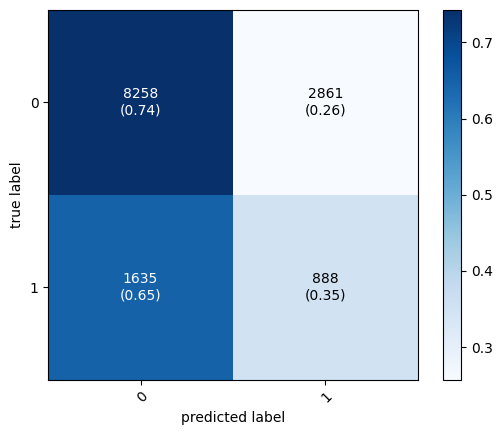

[INFO] model nb demoró 0.004367800000000001 minutos en ejecutar
nbm


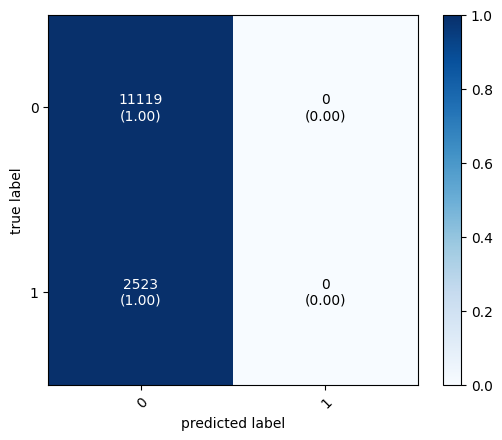

[INFO] model nbm demoró 0.003491866666666667 minutos en ejecutar


In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)
models = ["rf","rl","xgb","nb","nbm"]
for model in models:
    start_iter = datetime.now()
    print(model)
    if model == "rf":
        grid_under = GridSearchCV(RandomForestClassifier(), param_rf, refit=True, verbose=1, scoring="f1_weighted")
    elif model == "rl":
        grid_under = GridSearchCV(LogisticRegression(), param_log, refit=True, verbose=1, scoring="f1_weighted")
    elif model == "nb":
        grid_under = GaussianNB()
    elif model == "xgb":
        grid_under = GridSearchCV(XGBClassifier(), param_xgb, refit=True, verbose=1, scoring="f1_weighted")
    elif model == "nbm":
        grid_under = MultinomialNB()
    path_model_save = f"models/atraso_completo/{model}.pickle"
    grid_under.fit(X_train, y_train)
    y_pred = grid_under.predict(X_test)
    metrics_res = get_report(y_test, y_pred)
    metrics_res["modelo"] = model
    metrics_res["tipo_modelo"] = "atraso_completo"
    if metrics is None:
        metrics_res.to_parquet(path_metrics)
        metrics = pd.read_parquet(path_metrics)
    else:
        metrics = pd.read_parquet(path_metrics)
        metrics_res = pd.concat([metrics,metrics_res])
        metrics_res.to_parquet(path_metrics)
    with open(path_model_save,"wb") as f:
        pickle.dump(grid_under,f)
    end_iter = datetime.now()
    print(f"[INFO] model {model} demoró {(end_iter-start_iter).total_seconds()/60} minutos en ejecutar")

# Entrenamiento de modelos por momento del día

rf
Fitting 5 folds for each of 60 candidates, totalling 300 fits


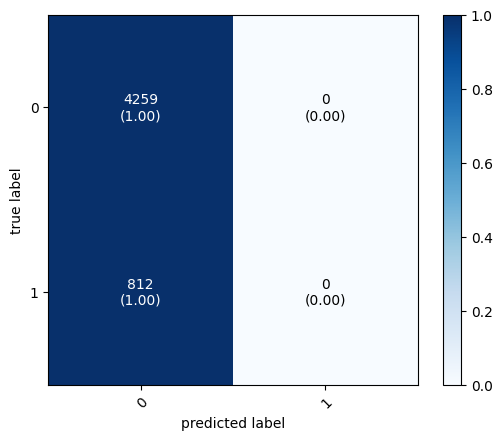

[INFO] model rf demoró 1.3418081166666667 minutos en ejecutar
rl
Fitting 5 folds for each of 30 candidates, totalling 150 fits


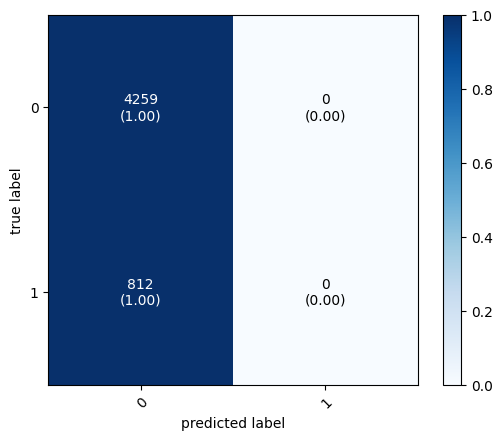

[INFO] model rl demoró 0.5696902166666666 minutos en ejecutar
xgb
Fitting 5 folds for each of 18 candidates, totalling 90 fits


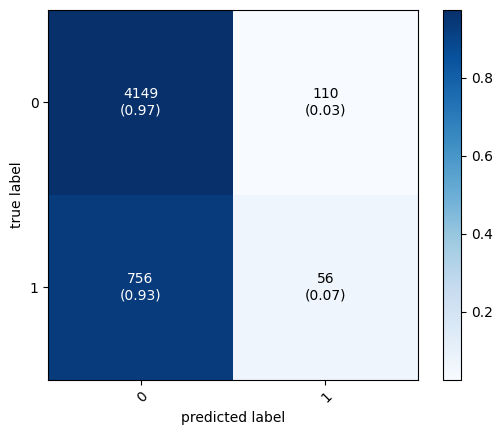

[INFO] model xgb demoró 0.9245547833333333 minutos en ejecutar
nb


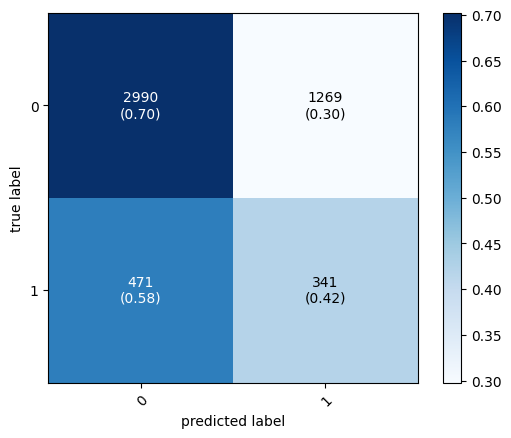

[INFO] model nb demoró 0.0038048833333333334 minutos en ejecutar
nbm


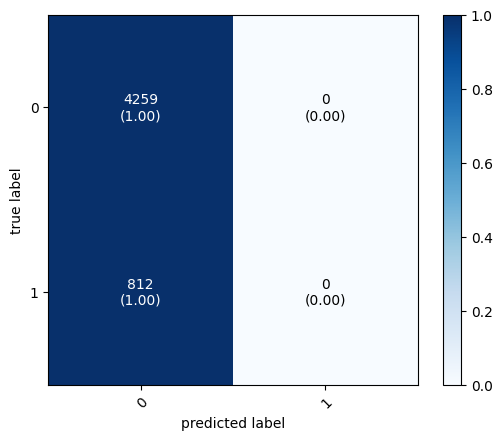

[INFO] model nbm demoró 0.0028721333333333334 minutos en ejecutar
rf
Fitting 5 folds for each of 60 candidates, totalling 300 fits


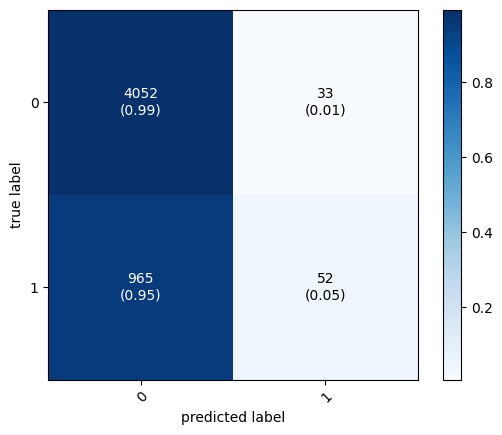

[INFO] model rf demoró 1.3099963499999998 minutos en ejecutar
rl
Fitting 5 folds for each of 30 candidates, totalling 150 fits


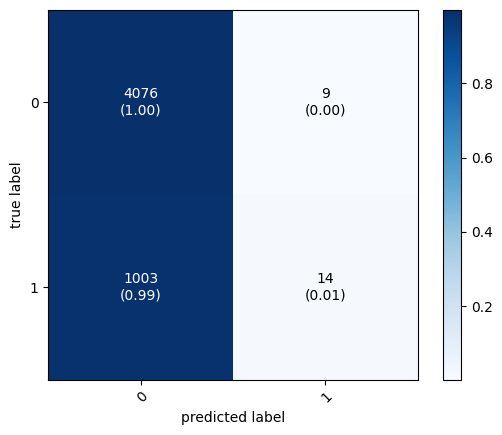

[INFO] model rl demoró 0.56466445 minutos en ejecutar
xgb
Fitting 5 folds for each of 18 candidates, totalling 90 fits


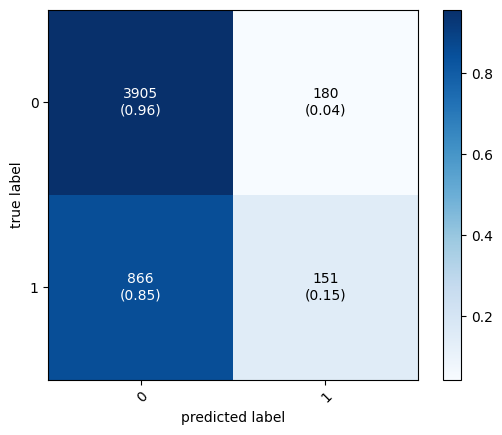

[INFO] model xgb demoró 0.9803503666666666 minutos en ejecutar
nb


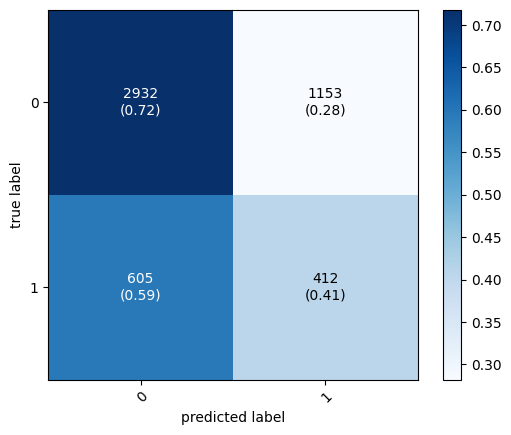

[INFO] model nb demoró 0.00382725 minutos en ejecutar
nbm


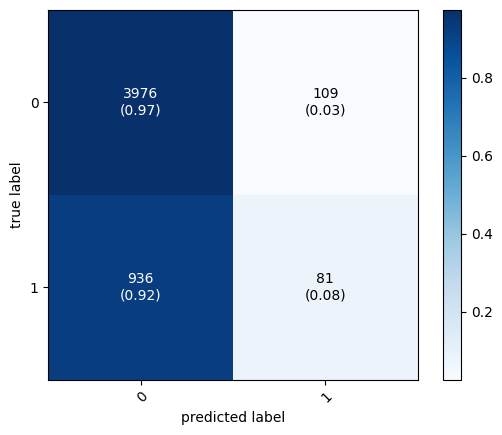

[INFO] model nbm demoró 0.0029609000000000003 minutos en ejecutar
rf
Fitting 5 folds for each of 60 candidates, totalling 300 fits


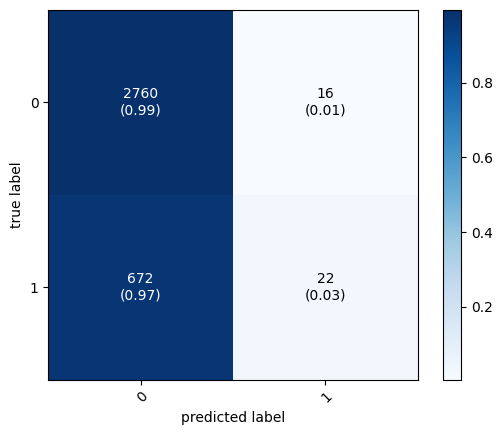

[INFO] model rf demoró 0.9872419833333334 minutos en ejecutar
rl
Fitting 5 folds for each of 30 candidates, totalling 150 fits


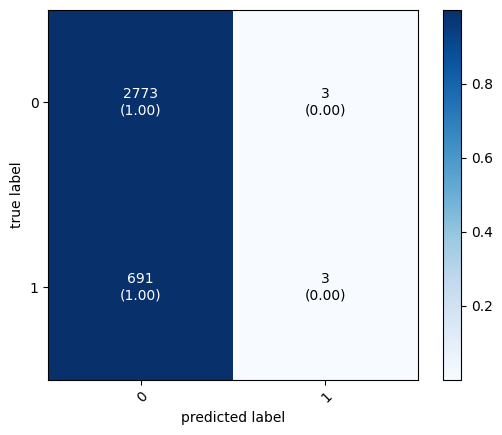

[INFO] model rl demoró 0.40293765000000004 minutos en ejecutar
xgb
Fitting 5 folds for each of 18 candidates, totalling 90 fits


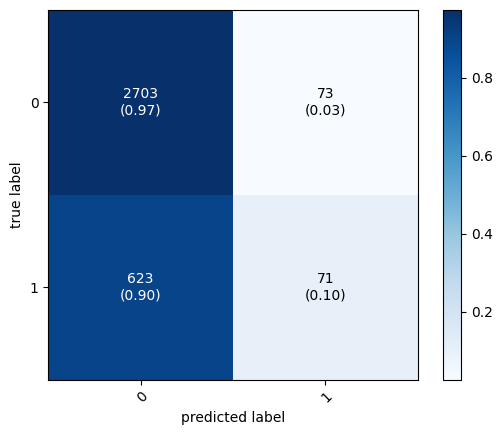

[INFO] model xgb demoró 0.6547939166666666 minutos en ejecutar
nb


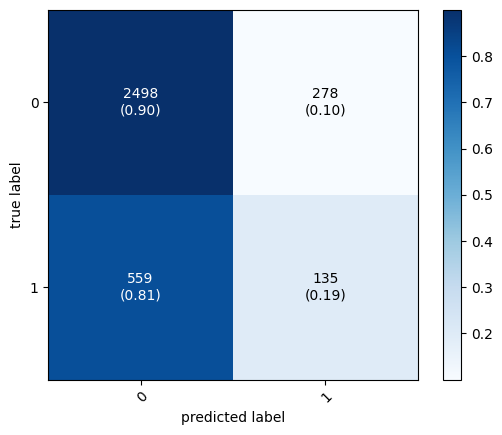

[INFO] model nb demoró 0.0030990333333333333 minutos en ejecutar
nbm


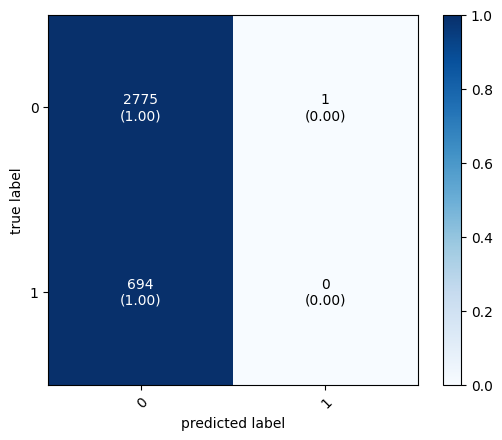

[INFO] model nbm demoró 0.0027455166666666667 minutos en ejecutar


In [48]:
momento_dia = ["mañana","tarde","noche"]
models = ["rf","rl","xgb","nb","nbm"]
for dia in momento_dia:
    df_filter = df[df["PERIODO_DIA"]==dia]
    if dia == "mañana":
        dia = "manana"
    df_feat = df_filter[features]
    var_cat = [col for col in df_feat.columns if col not in var_num]
    var_dummies = pd.get_dummies(df_feat[var_cat])
    var_dummies[var_num[0]] = df[[var_num[0]]]
    var_dummies[var_num[1]] = df[[var_num[1]]]
    X = var_dummies
    y = df_filter[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

    for model in models:
        start_iter = datetime.now()
        print(model)
        if model == "rf":
            grid_under = GridSearchCV(RandomForestClassifier(), param_rf, refit=True, verbose=1,scoring="f1_weighted")
        elif model == "rl":
            grid_under = GridSearchCV(LogisticRegression(), param_log, refit=True, verbose=1,scoring="f1_weighted")
        elif model == "nb":
            grid_under = GaussianNB()
        elif model == "xgb":
            grid_under = GridSearchCV(XGBClassifier(), param_xgb, refit=True, verbose=1,scoring="f1_weighted")
        elif model == "nbm":
            grid_under = MultinomialNB()
        path_model_save = f"models/atraso_{dia}/{model}.pickle"
        grid_under.fit(X_train, y_train)
        y_pred = grid_under.predict(X_test)
        metrics_res = get_report(y_test, y_pred)
        metrics_res["modelo"] = model
        metrics_res["tipo_modelo"] = f"atraso_{dia}"
        if metrics is None:
            metrics_res.to_parquet(path_metrics)
            metrics = pd.read_parquet(path_metrics)
        else:
            metrics = pd.read_parquet(path_metrics)
            metrics_res = pd.concat([metrics,metrics_res])
            metrics_res.to_parquet(path_metrics)
        with open(path_model_save,"wb") as f:
            pickle.dump(grid_under,f)
        end_iter = datetime.now()
        print(f"[INFO] model {model} demoró {(end_iter-start_iter).total_seconds()/60} minutos en ejecutar")

# Entrenamiento de modelos por día de la semana

rf
Fitting 5 folds for each of 60 candidates, totalling 300 fits


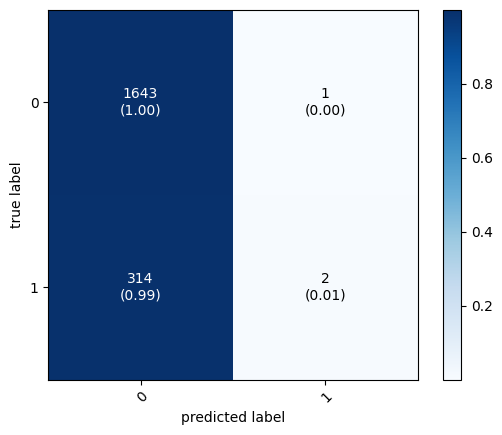

[INFO] model rf demoró 0.6671136833333333 minutos en ejecutar
rl
Fitting 5 folds for each of 30 candidates, totalling 150 fits


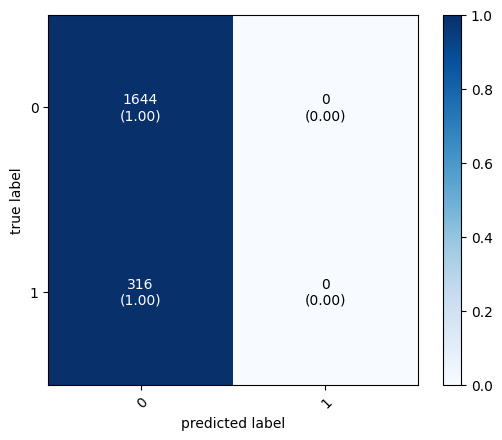

[INFO] model rl demoró 0.11034748333333333 minutos en ejecutar
xgb
Fitting 5 folds for each of 18 candidates, totalling 90 fits


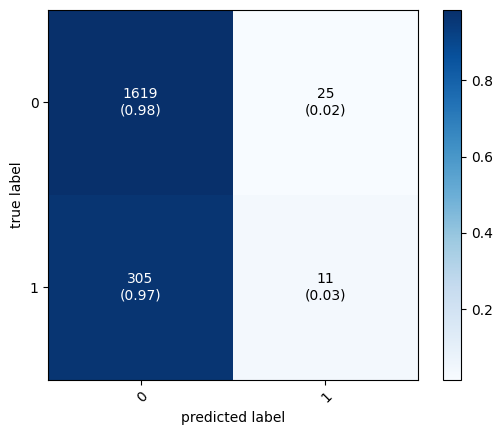

[INFO] model xgb demoró 0.2543755 minutos en ejecutar
nb


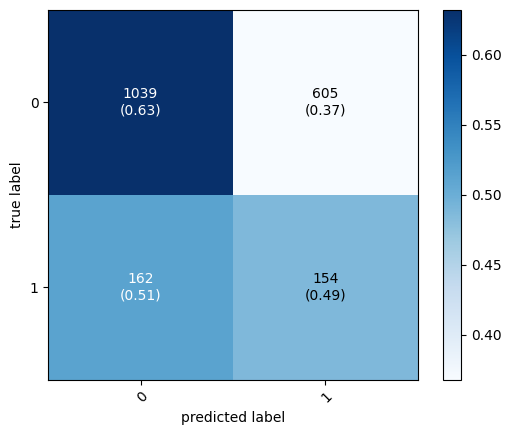

[INFO] model nb demoró 0.002605266666666667 minutos en ejecutar
nbm


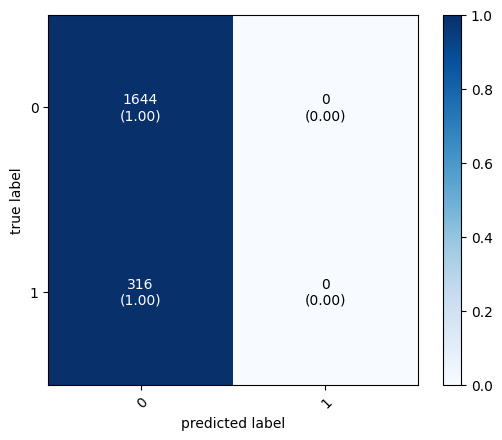

[INFO] model nbm demoró 0.0024818 minutos en ejecutar
rf
Fitting 5 folds for each of 60 candidates, totalling 300 fits


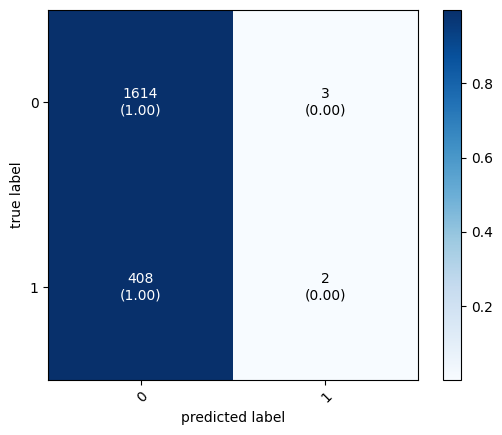

[INFO] model rf demoró 0.6387291 minutos en ejecutar
rl
Fitting 5 folds for each of 30 candidates, totalling 150 fits


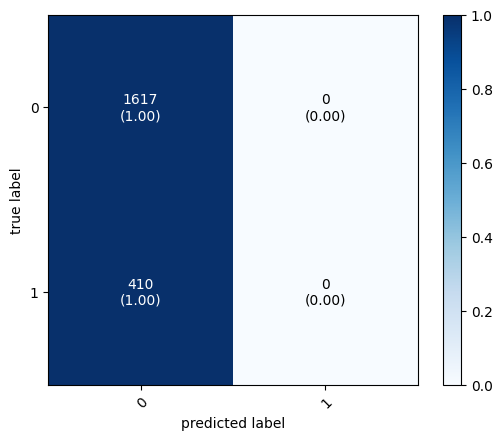

[INFO] model rl demoró 0.14638281666666667 minutos en ejecutar
xgb
Fitting 5 folds for each of 18 candidates, totalling 90 fits


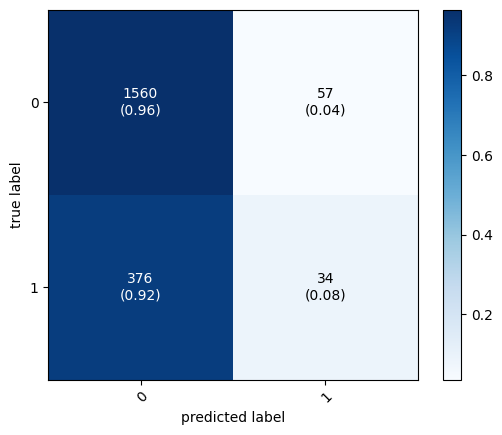

[INFO] model xgb demoró 0.31832555 minutos en ejecutar
nb


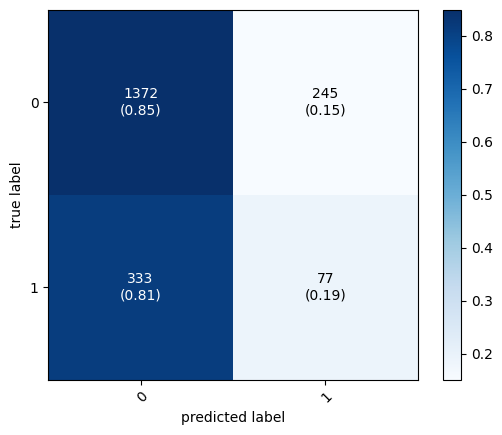

[INFO] model nb demoró 0.00285675 minutos en ejecutar
nbm


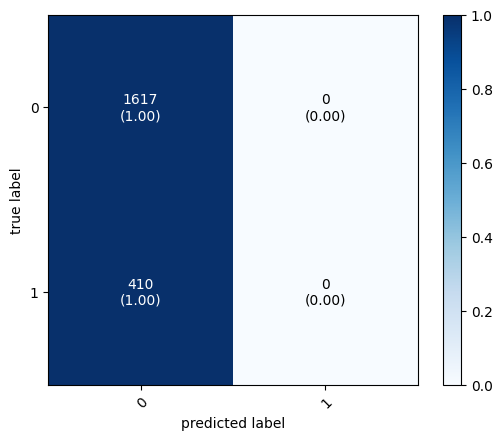

[INFO] model nbm demoró 0.002934616666666667 minutos en ejecutar
rf
Fitting 5 folds for each of 60 candidates, totalling 300 fits


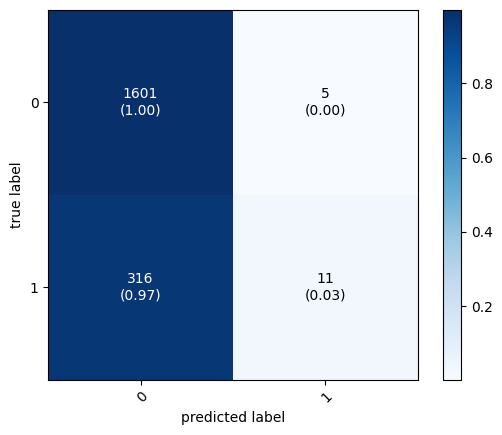

[INFO] model rf demoró 0.6229721833333334 minutos en ejecutar
rl
Fitting 5 folds for each of 30 candidates, totalling 150 fits


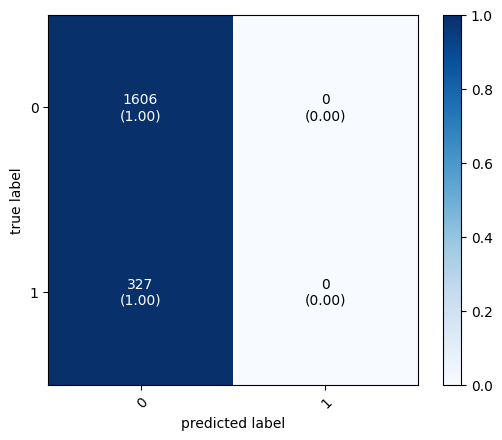

[INFO] model rl demoró 0.10662221666666666 minutos en ejecutar
xgb
Fitting 5 folds for each of 18 candidates, totalling 90 fits


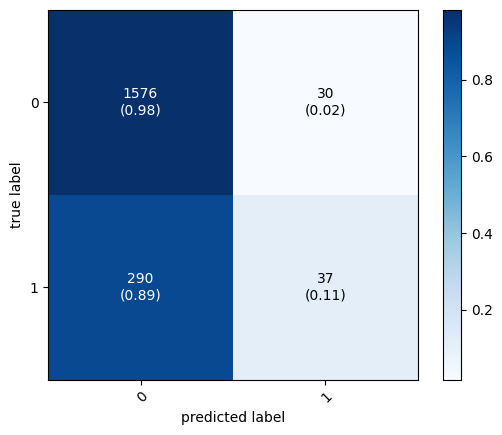

[INFO] model xgb demoró 0.27517595 minutos en ejecutar
nb


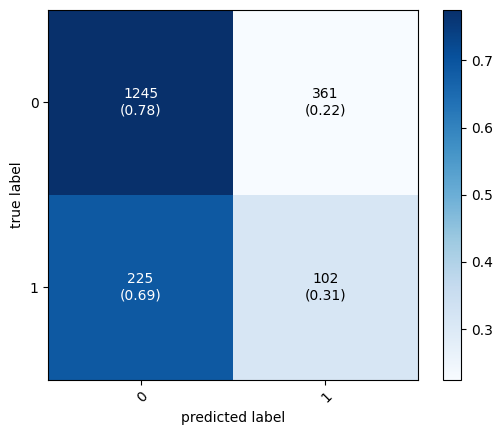

[INFO] model nb demoró 0.0027607499999999997 minutos en ejecutar
nbm


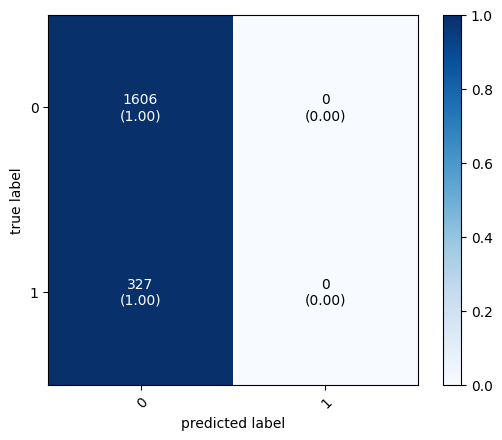

[INFO] model nbm demoró 0.0029141166666666668 minutos en ejecutar
rf
Fitting 5 folds for each of 60 candidates, totalling 300 fits


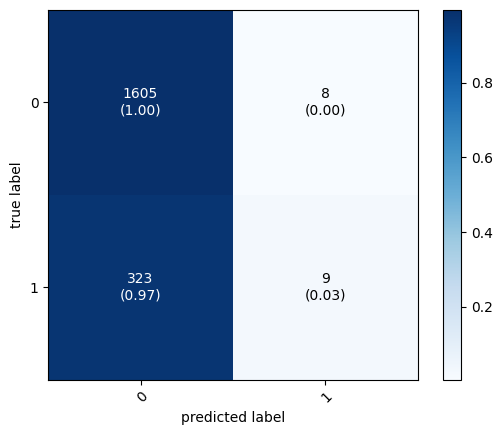

[INFO] model rf demoró 0.6299338833333333 minutos en ejecutar
rl
Fitting 5 folds for each of 30 candidates, totalling 150 fits


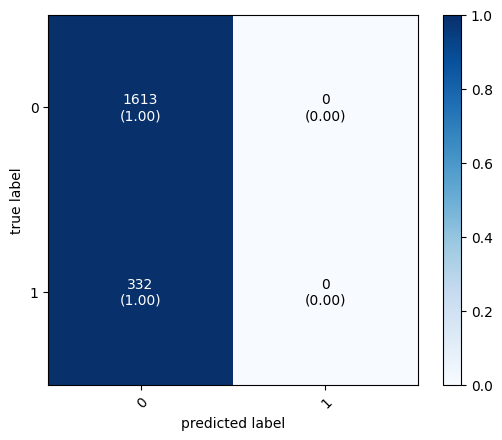

[INFO] model rl demoró 0.10682873333333333 minutos en ejecutar
xgb
Fitting 5 folds for each of 18 candidates, totalling 90 fits


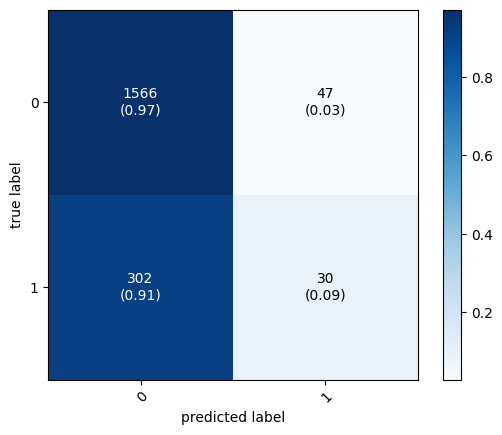

[INFO] model xgb demoró 0.26789151666666666 minutos en ejecutar
nb


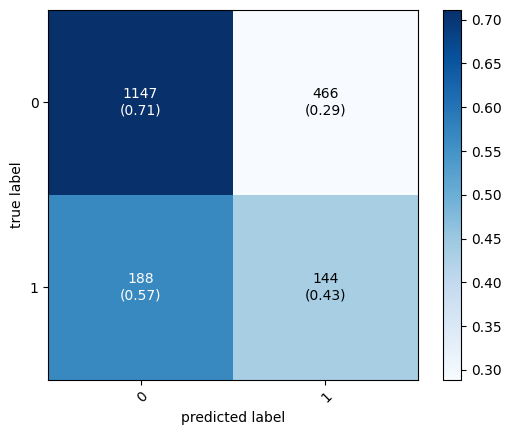

[INFO] model nb demoró 0.0029040333333333335 minutos en ejecutar
nbm


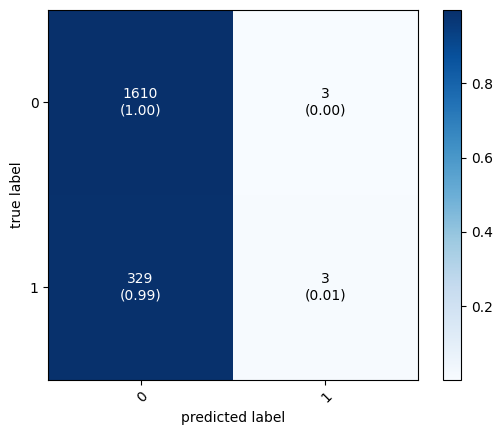

[INFO] model nbm demoró 0.0028546666666666664 minutos en ejecutar
rf
Fitting 5 folds for each of 60 candidates, totalling 300 fits


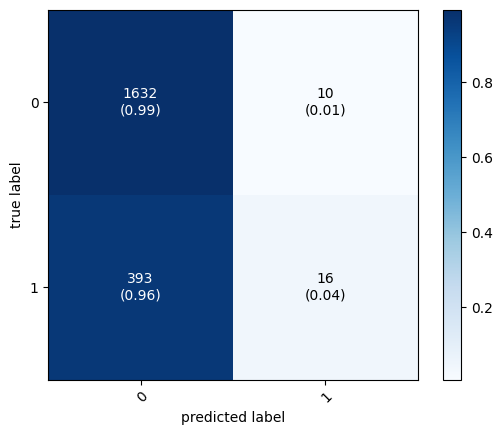

[INFO] model rf demoró 0.6466830333333333 minutos en ejecutar
rl
Fitting 5 folds for each of 30 candidates, totalling 150 fits


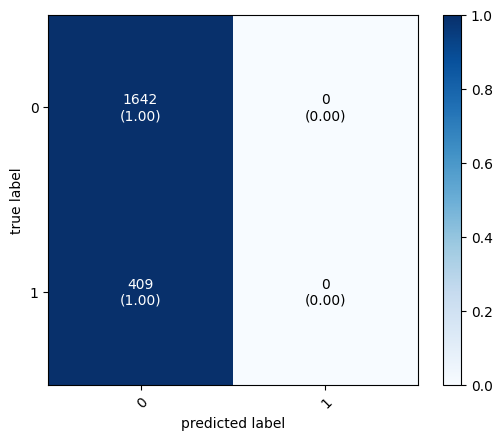

[INFO] model rl demoró 0.122927 minutos en ejecutar
xgb
Fitting 5 folds for each of 18 candidates, totalling 90 fits


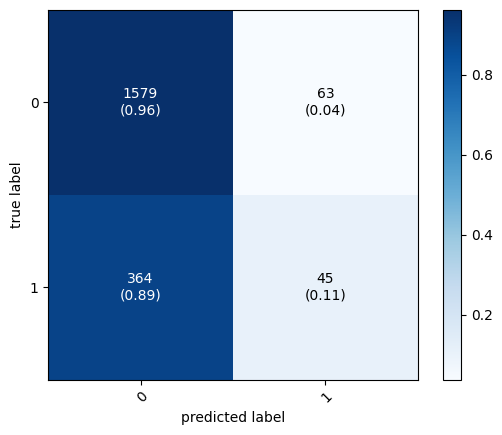

[INFO] model xgb demoró 0.3113669 minutos en ejecutar
nb


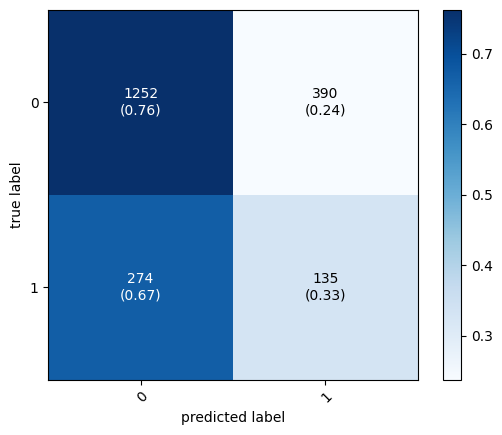

[INFO] model nb demoró 0.0028158666666666665 minutos en ejecutar
nbm


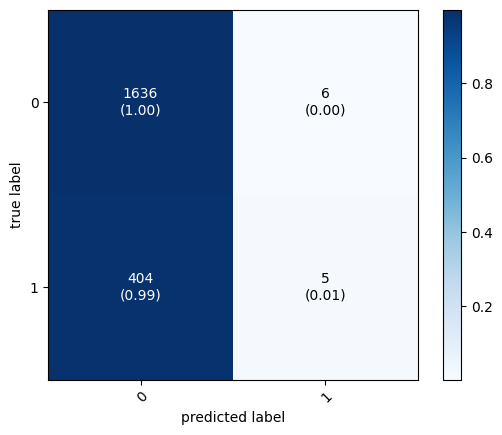

[INFO] model nbm demoró 0.0026202166666666666 minutos en ejecutar
rf
Fitting 5 folds for each of 60 candidates, totalling 300 fits


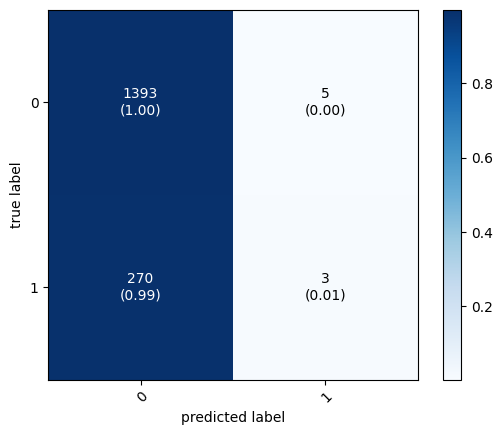

[INFO] model rf demoró 0.58906035 minutos en ejecutar
rl
Fitting 5 folds for each of 30 candidates, totalling 150 fits


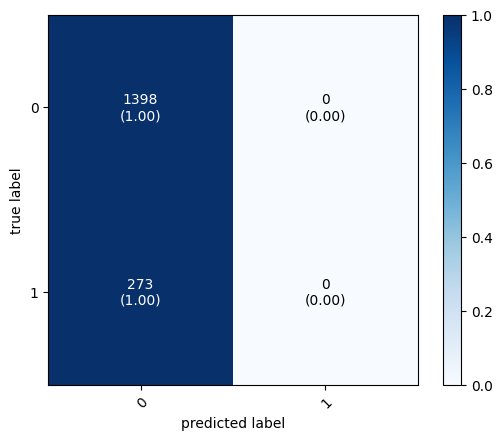

[INFO] model rl demoró 0.08467755 minutos en ejecutar
xgb
Fitting 5 folds for each of 18 candidates, totalling 90 fits


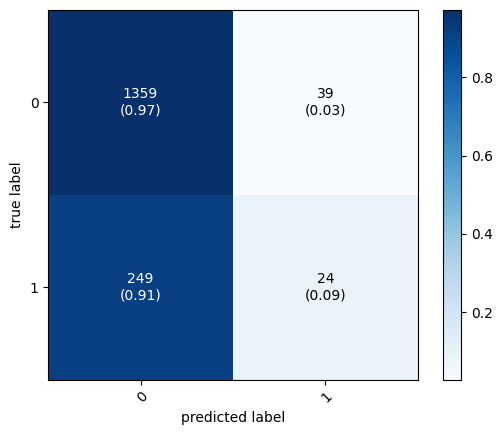

[INFO] model xgb demoró 0.26274423333333335 minutos en ejecutar
nb


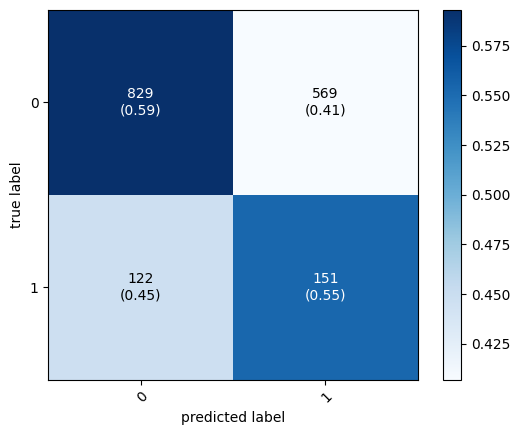

[INFO] model nb demoró 0.0031320833333333335 minutos en ejecutar
nbm


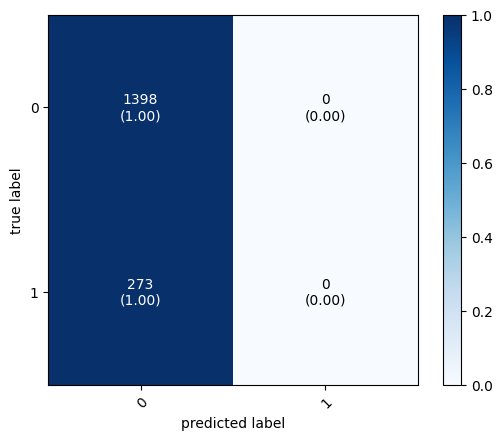

[INFO] model nbm demoró 0.0026968666666666668 minutos en ejecutar
rf
Fitting 5 folds for each of 60 candidates, totalling 300 fits


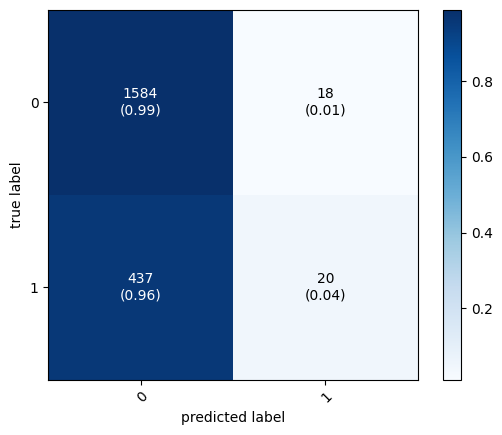

[INFO] model rf demoró 0.6942547833333333 minutos en ejecutar
rl
Fitting 5 folds for each of 30 candidates, totalling 150 fits


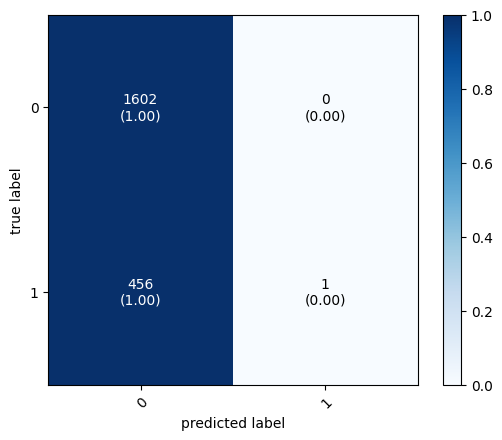

[INFO] model rl demoró 0.12910053333333332 minutos en ejecutar
xgb
Fitting 5 folds for each of 18 candidates, totalling 90 fits


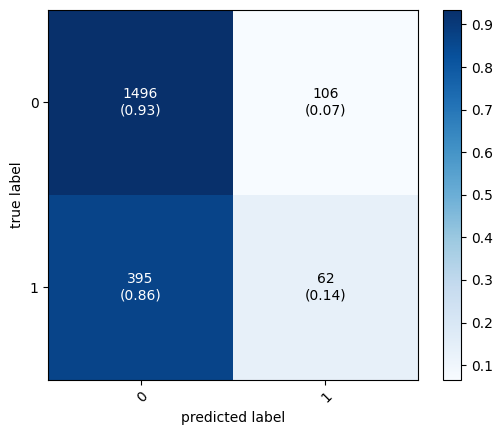

[INFO] model xgb demoró 0.3617834833333333 minutos en ejecutar
nb


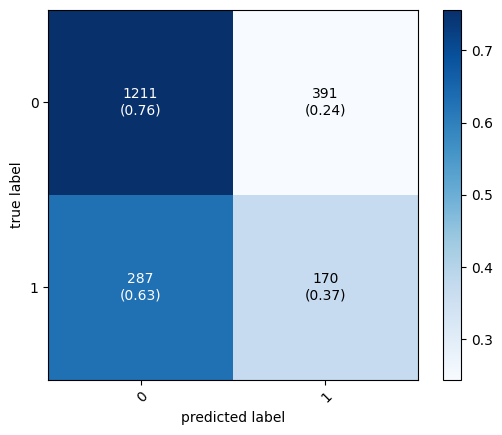

[INFO] model nb demoró 0.002859533333333333 minutos en ejecutar
nbm


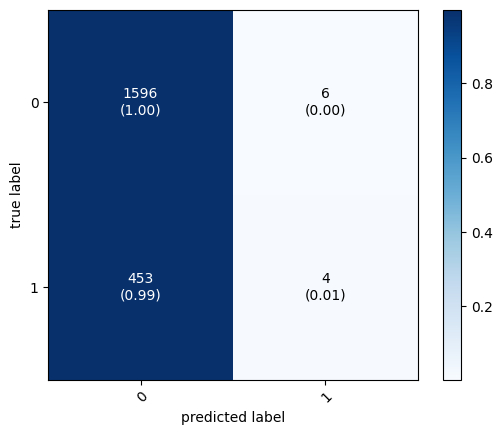

[INFO] model nbm demoró 0.0028451333333333333 minutos en ejecutar


In [49]:
dia_semana = df["DIANOM"].drop_duplicates().tolist()
for dia in dia_semana:
    df_filter = df[df["DIANOM"]==dia]
    dia = dia.lower()
    df_feat = df_filter[features]
    var_cat = [col for col in df_feat.columns if col not in var_num]
    var_dummies = pd.get_dummies(df_feat[var_cat])
    var_dummies[var_num[0]] = df[[var_num[0]]]
    var_dummies[var_num[1]] = df[[var_num[1]]]
    X = var_dummies
    y = df_filter[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

    models = ["rf","rl","xgb","nb","nbm"]
    for model in models:
        start_iter = datetime.now()
        print(model)
        if model == "rf":
            grid_under = GridSearchCV(RandomForestClassifier(), param_rf, refit = True, verbose = 1,scoring="f1_weighted")
        elif model == "rl":
            grid_under = GridSearchCV(LogisticRegression(), param_log, refit = True, verbose = 1,scoring="f1_weighted")
        elif model == "nb":
            grid_under = GaussianNB()
        elif model == "xgb":
            grid_under = GridSearchCV(XGBClassifier(), param_xgb, refit = True, verbose = 1,scoring="f1_weighted")
        elif model == "nbm":
            grid_under = MultinomialNB()
        path_model_save = f"models/atraso_{dia}/{model}.pickle"
        grid_under.fit(X_train, y_train)
        y_pred = grid_under.predict(X_test)
        metrics_res = get_report(y_test, y_pred)
        metrics_res["modelo"] = model
        metrics_res["tipo_modelo"] = f"atraso_{dia}"
        if metrics is None:
            metrics_res.to_parquet(path_metrics)
            metrics = pd.read_parquet(path_metrics)
        else:
            metrics = pd.read_parquet(path_metrics)
            metrics_res = pd.concat([metrics,metrics_res])
            metrics_res.to_parquet(path_metrics)
        with open(path_model_save,"wb") as f:
            pickle.dump(grid_under,f)
        end_iter = datetime.now()
        print(f"[INFO] model {model} demoró {(end_iter-start_iter).total_seconds()/60} minutos en ejecutar")

In [50]:
metrics_models = pd.read_parquet(path_metrics)
metrics_models = metrics_models.reset_index()

In [54]:
metrics_models.head()

,index,precision,recall,f1-score,support,modelo,tipo_modelo
0,0,0.816585,0.999011,0.898633,11119.000000,rf,atraso_completo
1,1,0.717949,0.011098,0.021858,2523.000000,rf,atraso_completo
2,accuracy,0.816303,0.816303,0.816303,0.816303,rf,atraso_completo
3,macro avg,0.767267,0.505054,0.460245,13642.000000,rf,atraso_completo
4,weighted avg,0.798343,0.816303,0.736479,13642.000000,rf,atraso_completo


In [56]:
metrics_models[metrics_models["index"]=='1'].sort_values(["tipo_modelo","f1-score"],ascending=[False,False])\
                .drop_duplicates(["tipo_modelo"]).sort_values("f1-score",ascending=False)

,index,precision,recall,f1-score,support,modelo,tipo_modelo
266,1,0.303030,0.371991,0.333988,457.0,nb,atraso_viernes
66,1,0.263259,0.405113,0.319132,1017.0,nb,atraso_tarde
191,1,0.236066,0.433735,0.305732,332.0,nb,atraso_miercoles
241,1,0.209722,0.553114,0.304129,273.0,nb,atraso_sabado
216,1,0.257143,0.330073,0.289079,409.0,nb,atraso_jueves
116,1,0.202899,0.487342,0.286512,316.0,nb,atraso_domingo
16,1,0.236863,0.351962,0.283163,2523.0,nb,atraso_completo
41,1,0.211801,0.419951,0.281585,812.0,nb,atraso_manana
166,1,0.220302,0.311927,0.258228,327.0,nb,atraso_martes
91,1,0.326877,0.194524,0.243902,694.0,nb,atraso_noche


# Conclusiones

En la búsqueda de encontrar un buen modelo que nos prediga si un vuelo va a tener retraso o no, encontramos las siguientes observaciones:
- Las variables que se disponen no logran predecir el atraso de un vuelo a un nivel significativo. Un supuesto que se maneja es que puede ser debido a que la gran mayoría son variables del tipo categóricas.
- Los mejores modelos que se lograron capturar fueron por momento del día, en particular, durante la tarde (entre las 12:00 y las 18:59 hrs).
- De los diferentes modelos con su respectivo tuning de hiperparámetros el que mejor rendimiento tuvo fueron las Redes Bayesianas, quedándose con el podio en cada uno de los modelos definidos.
- Por los resultados vistos anteriormente, puedo decir, que los modelos de RL no convergen y por eso se vieron tan malos resultados en sus modelos.
- Las Redes Bayesianas Multinomiales no performaron bien, logrando un desempeño muy similar a la Regresión Logística.

### Los modelos utilizados fueron:
- Redes Bayesianas, debido a su simplicidad de construcción y no requiere supuestos de entrada.
- Redes Bayesianas Multinomial.
- Random Forest, debido a que es un modelo no-paramétrico con baja cantidad de supuestos y suavizamiento de la salida debido a que se construyen n-árboles para que retorne la predicción.
- Xgboost, debido a que es un modelo sequencial que va aprendiendo de los errores del árbol anterior lo cual va construyendo un mejor modelo en cada iteración.+
- Regresión Logística, debido a que es un modelo probabilístico, no requiere normalidad (lo entregué bajo el supuesto que cómo la entrada que se dispone son variables categóricas es altamente probable que no performe muy bien debido a su distribución).

Las métricas se encuentran en un rango aceptable en los mejores modelos encontrados en este estudio. Sin embargo, tenemos que identificar cual es el rango de error que se dispone de parte de la Aerolínea para definir si es buen modelo, esto más tiene que ver más que nada con el error tipo I, es decir, aquellos vuelos que están siendo marcados con un retraso, pero realmente no tienen un retraso.

A nivel de números de las métricas, el mejor modelo obtenido fue para el día de la semana viernes, que obtuvo un 30%, 37% y un 33% para precision, recall y F1-score, respectivamente. Lo sigue el modelo del momento del día que es la tarde (entre las 12:00 hrs y las 18:59 hrs), logrando un 26%, 41% y 32% para precision, recall y F1-score.

No se consideró el accuracy y la curva ROC para este estudio, debido al desbalance de clases, sin embargo, es importante mencionar que el foco que se le dio a esta investigación fue intentar predecir de la mejor manera el atraso de un vuelo, concentrandose principalmente en los errores tipo I y tipo II. Además, dado el desbalance ya se sabe aproximandamente la vecindad en dónde va a encontrarse el accuracy y la curva ROC.

Recomendaría la viabilidad de considerar los modelos encontrados y plantear una forma de mezclar estos modelos para lograr la mayor capacidad predictiva para el atraso de un vuelo.

# Pasos futuros
- Consideraría agregar variables del clima como por ejemplo, la temperatura en ºC, si ha nevado en la cordillera (caso para aquellos vuelos que deben cruzar la cordillera)
- Tiempo de despeje de la vía (vuelo anterior).
- Embarque, entre otras variables que puedan conllevar a retrasar un vuelo.
- Generar un tuning de hiperparámetros más adecuado para las Redes Bayesianas.
- Agregar métricas de accuracy y curva ROC si se consideran relevantes para el estudio.